In [1]:
import pandas as pd
import numpy as np
from datetime import datetime as dt
import os
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import mpld3
import re
import math
from scipy.spatial import Voronoi, voronoi_plot_2d
from matplotlib.patches import Polygon, Patch
import matplotlib.image as mpimg
from matplotlib.ticker import ScalarFormatter

In [10]:
# These are the "Tableau 20" colors as RGB.    
tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),    
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),    
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),    
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),    
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]    
  
# Scale the RGB values to the [0, 1] range, which is the format matplotlib accepts.    
for i in range(len(tableau20)):    
    r, g, b = tableau20[i]    
    tableau20[i] = (r / 255., g / 255., b / 255.)

color = tableau20

plt.rcParams.update({'font.size': 22})

In [5]:
allFiles = glob.glob(os.path.join("..","interpolatedData","*","*.csv"))

df = {}
for x in allFiles:
    name = '_'.join(x.split(os.path.sep)[1:]).split('.')[0]
    df[name] = pd.read_csv(x,parse_dates=[0])
mergedDataFiles = glob.glob(os.path.join("..","..","mergedData","*.csv"))
mergedData = {(route.split("Data_")[1].split(".")[0]):pd.read_csv(route,parse_dates=[0]) for route in mergedDataFiles}
mergedDataFiles

['../../mergedData/mergedData_4-13-22.csv',
 '../../mergedData/mergedData_4-20-22.csv',
 '../../mergedData/mergedData_4-15-22.csv',
 '../../mergedData/mergedData_4-18-22.csv',
 '../../mergedData/mergedData_4-19-22.csv',
 '../../mergedData/mergedData_4-21-22.csv',
 '../../mergedData/mergedData_4-14-22.csv']

In [38]:
new = mergedData["4-13-22"].set_index("Date_Time").rolling(60*5, center = True).mean().dropna()
new.index


DatetimeIndex(['2022-04-13 10:02:30', '2022-04-13 10:02:31',
               '2022-04-13 10:02:32', '2022-04-13 10:02:33',
               '2022-04-13 10:02:34', '2022-04-13 10:02:35',
               '2022-04-13 10:02:36', '2022-04-13 10:02:37',
               '2022-04-13 10:02:38', '2022-04-13 10:02:39',
               ...
               '2022-04-13 16:57:12', '2022-04-13 16:57:13',
               '2022-04-13 16:57:14', '2022-04-13 16:57:15',
               '2022-04-13 16:57:16', '2022-04-13 16:57:17',
               '2022-04-13 16:57:18', '2022-04-13 16:57:19',
               '2022-04-13 16:57:20', '2022-04-13 16:57:21'],
              dtype='datetime64[ns]', name='Date_Time', length=24892, freq=None)

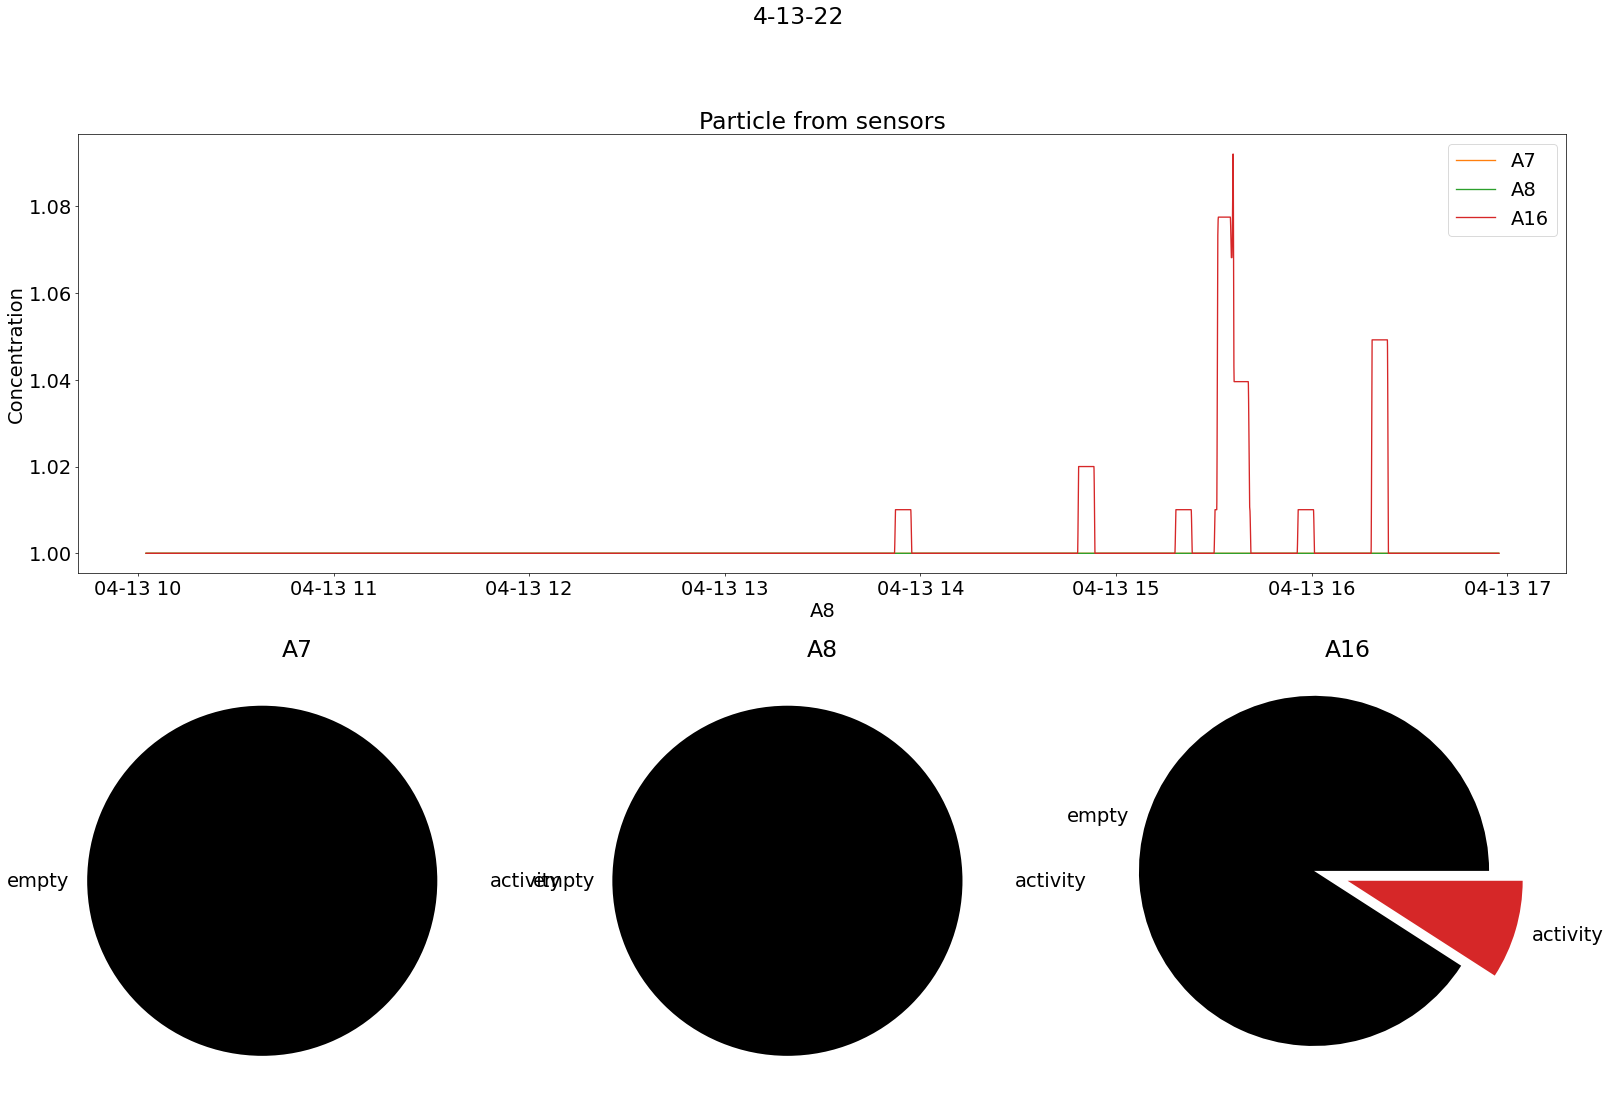

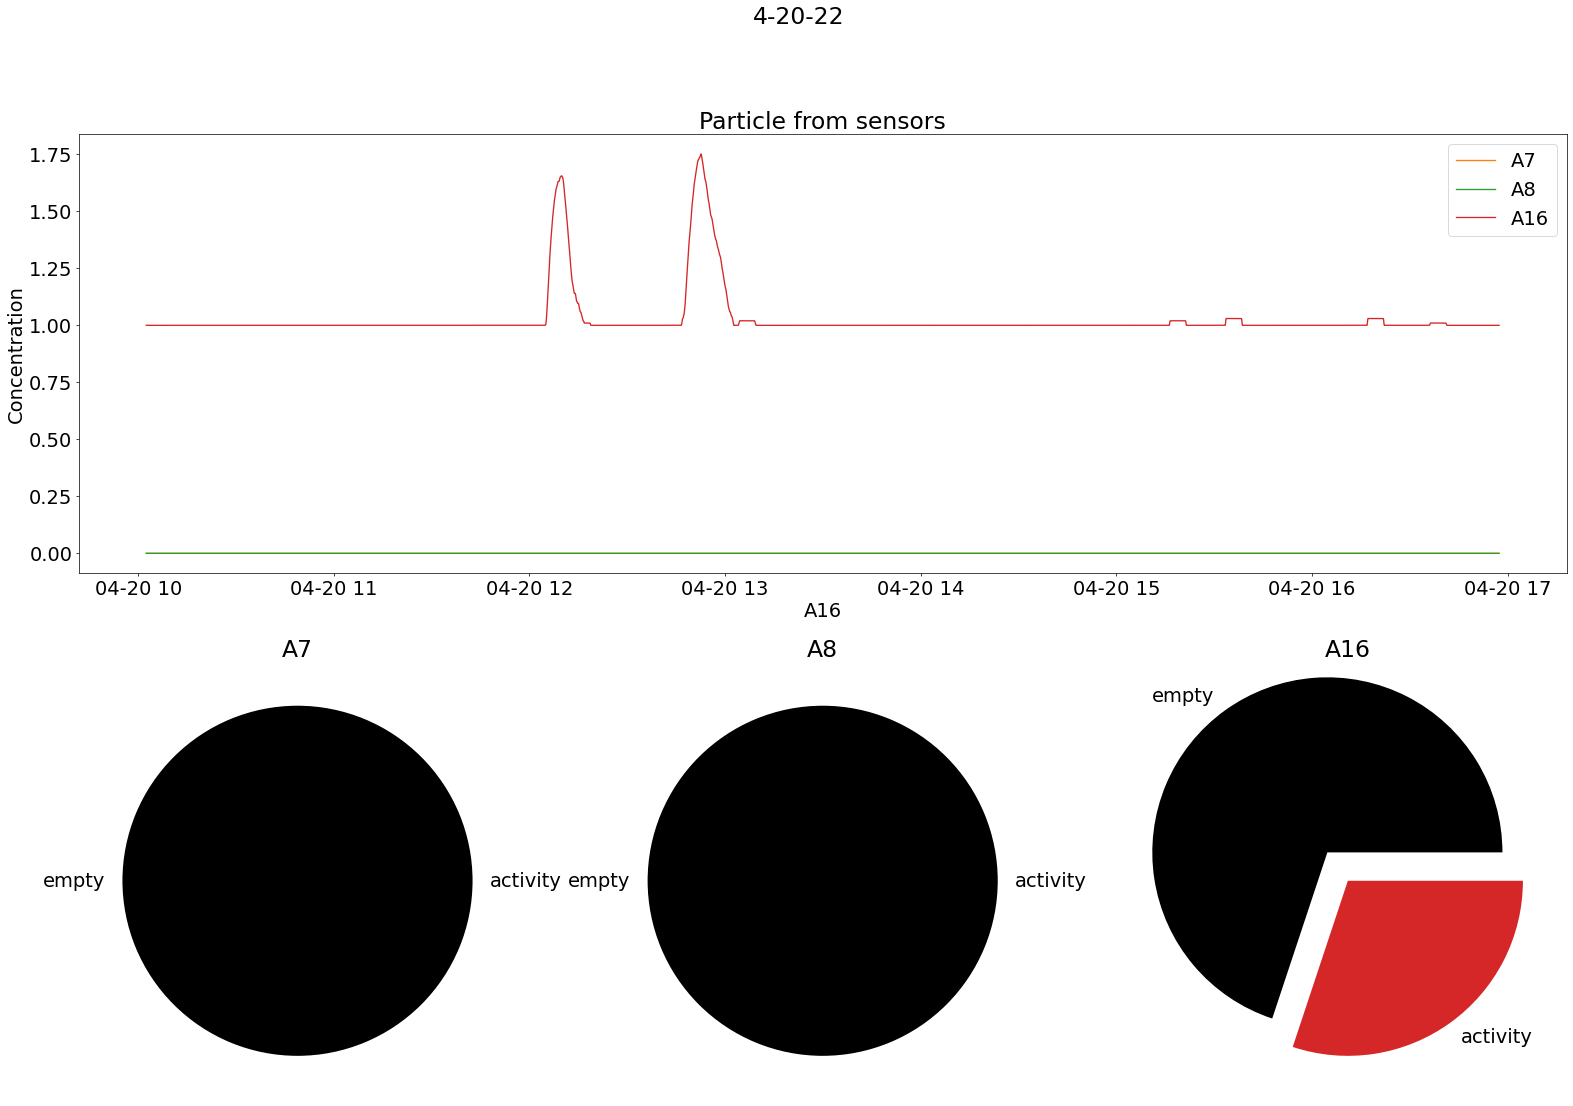

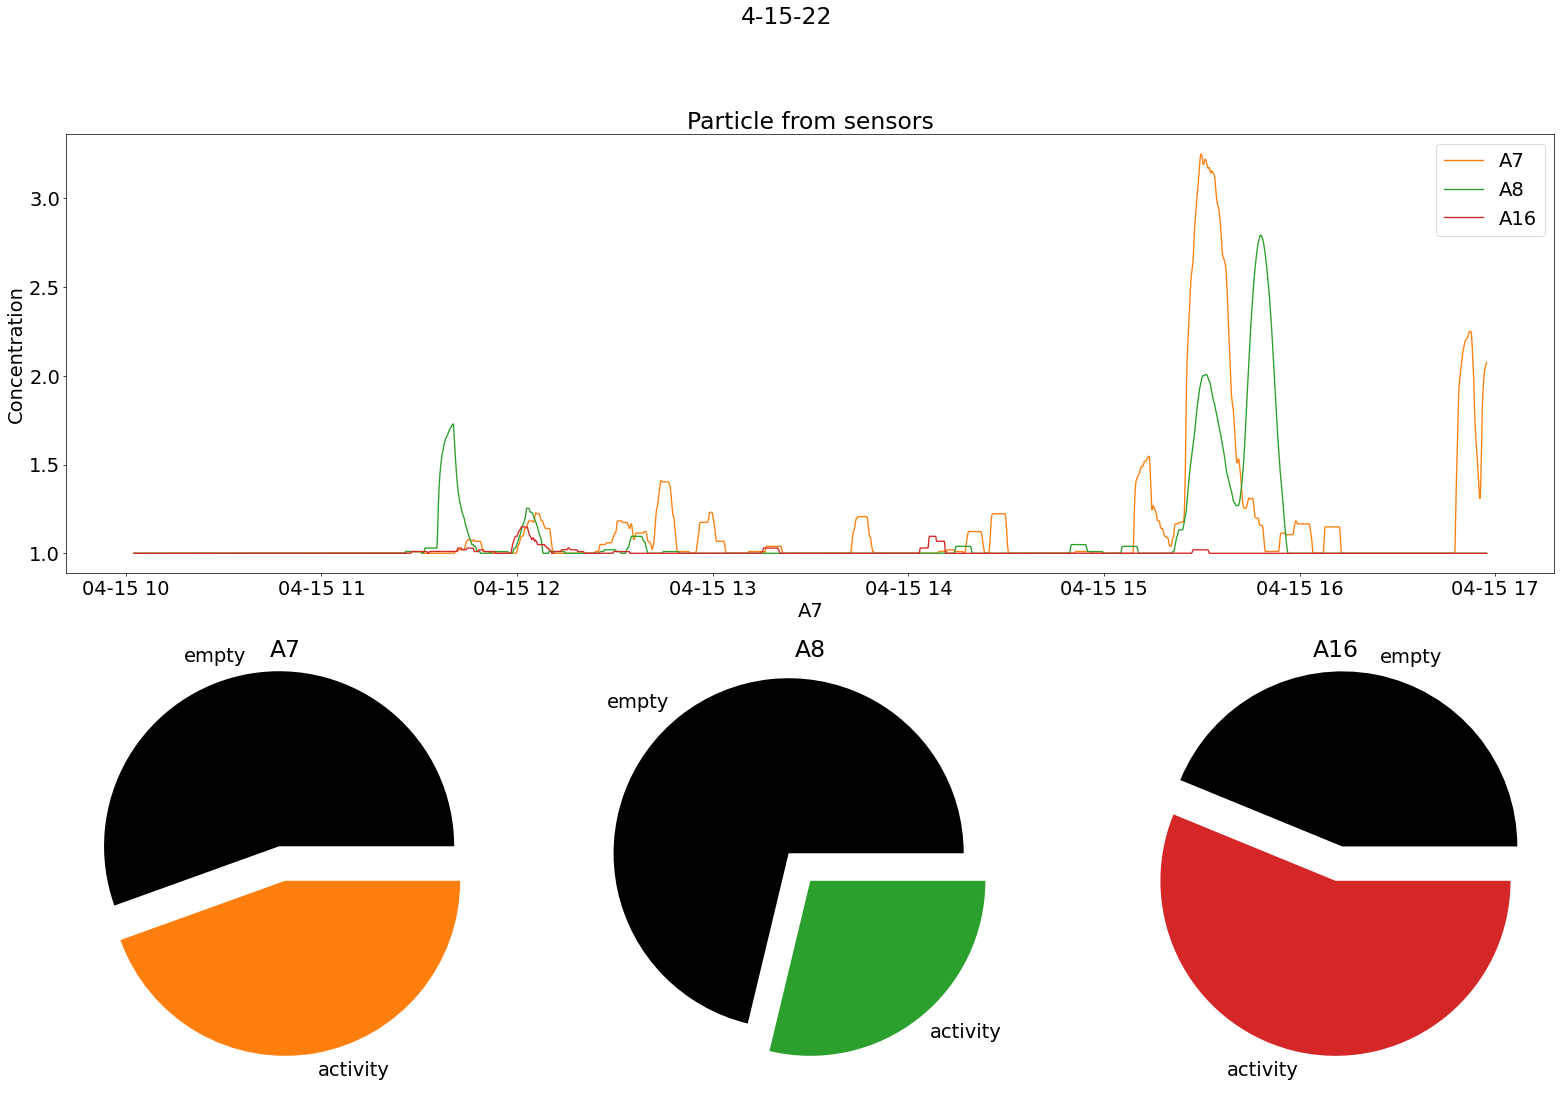

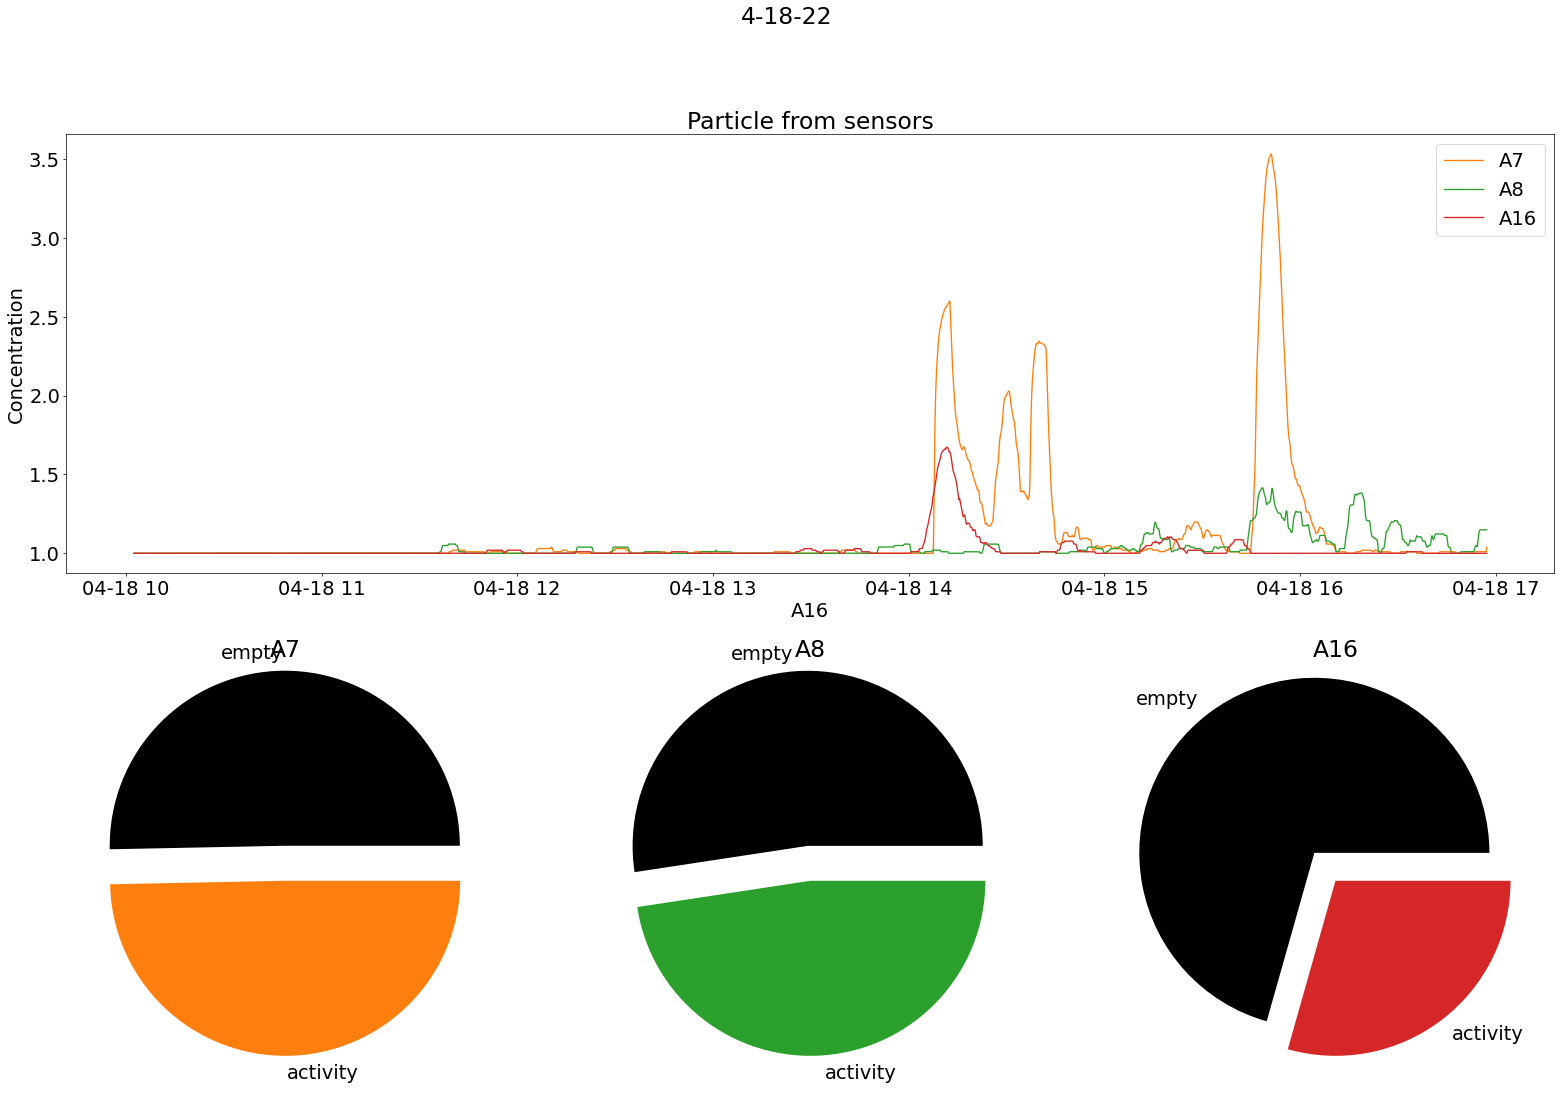

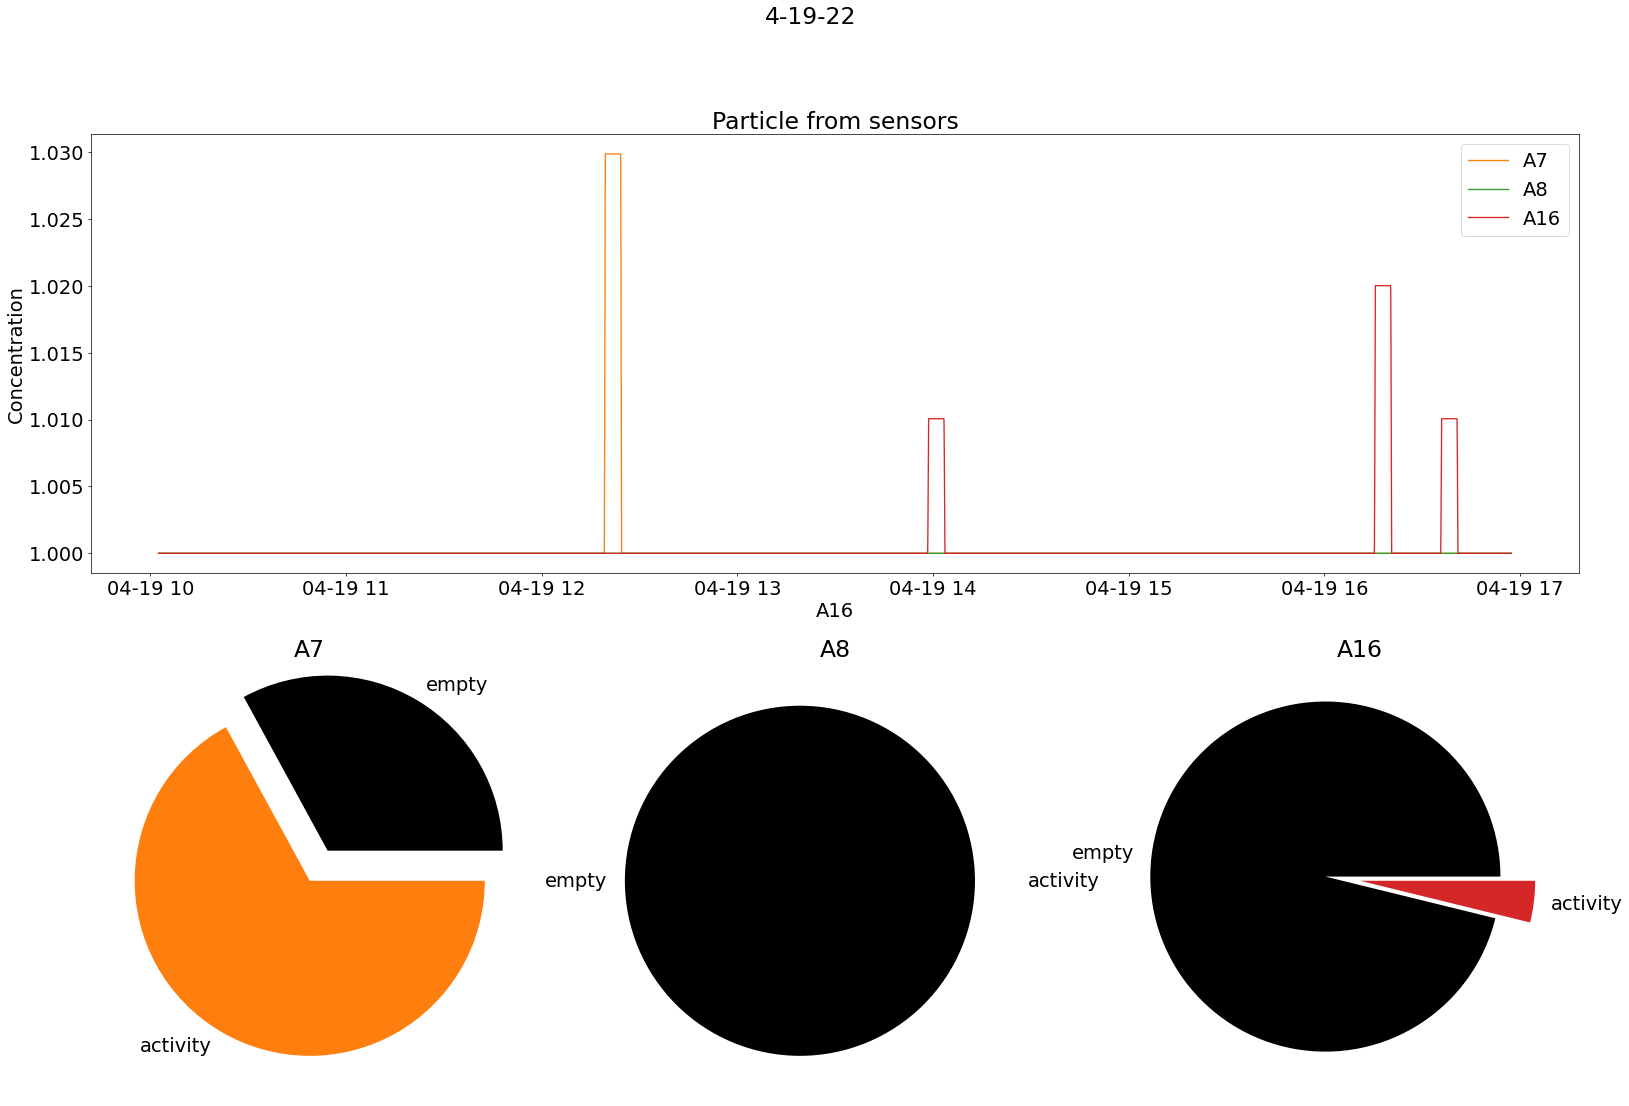

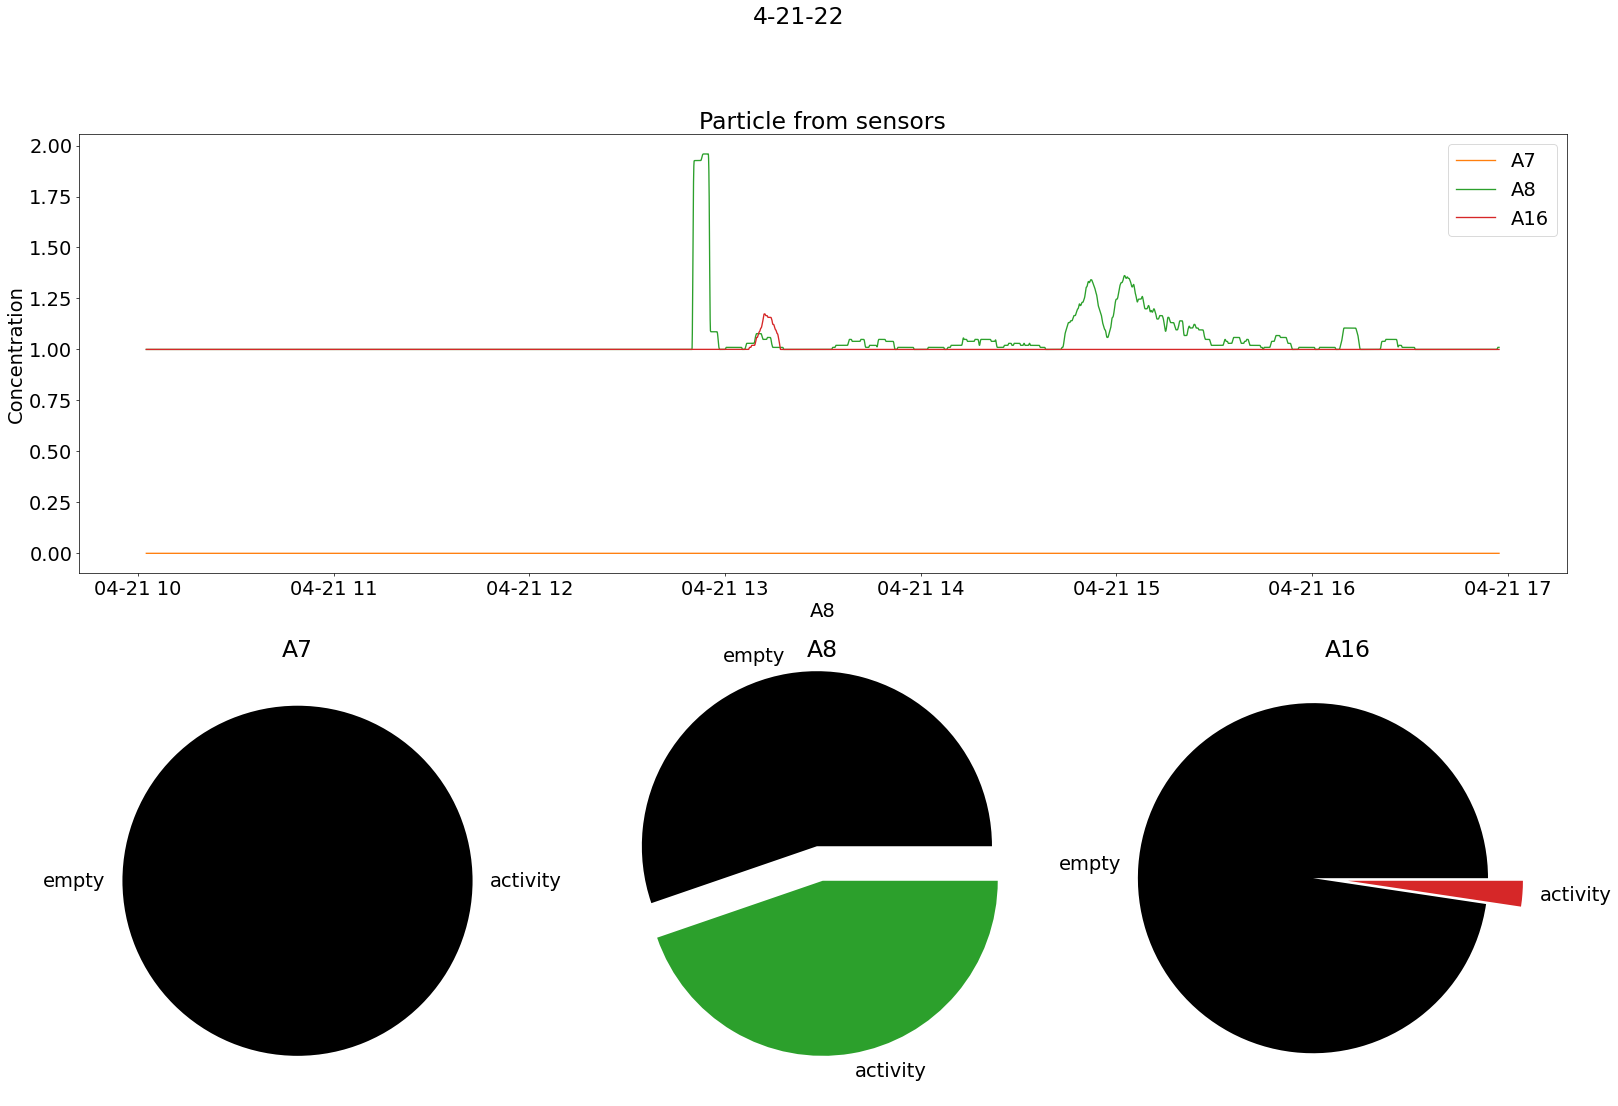

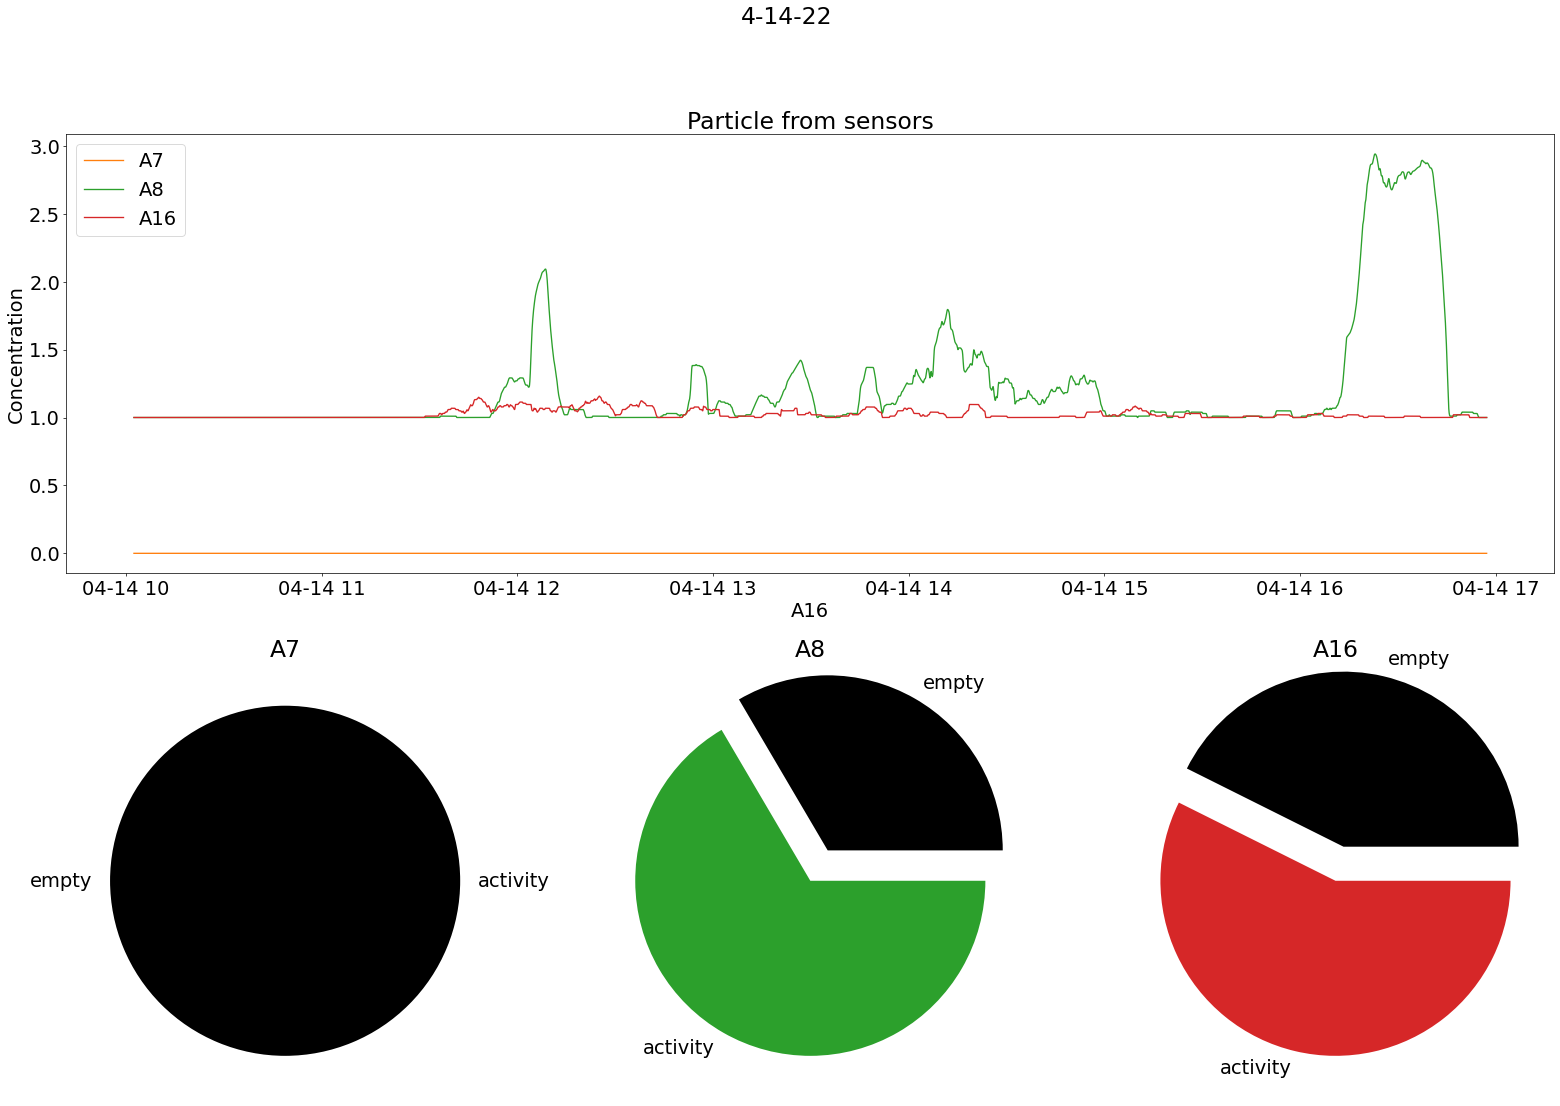

In [39]:
# print(mergedData)
for name, oldFrame in mergedData.items():
    sensors = ['A7', 'A8', 'A16']
    i = 1
    fig = plt.figure(figsize=(30,20), dpi=64)
    ax1= fig.add_subplot(2,1,1)
    ax2= fig.add_subplot(2,3,4)
    ax3= fig.add_subplot(2,3,5)
    ax4= fig.add_subplot(2,3,6)
    ax = [ax1,ax2,ax3,ax4]
    frame = oldFrame.set_index("Date_Time").rolling(60*5, center = True).mean().dropna()
    # frame.rolling(60*5, center = True).mean().dropna()

    for column in sensors:
        try:
            # ax.plot(frame.index,np.log(frame["Average"]+3)/np.log(3),'--',color = "black",label = "Average")
            emptyPercent = round(sum([1 if i == 0 else 0 for i in frame[column]])/len(frame[column])*100,2)
            # plt.title(f"% of empty cells: {emptyPercent}%")
            ax[0].plot(frame.index,np.log(frame[column]+3)/np.log(3),'-',color = color[i*2],label = f"{column}")# : {emptyPercent}% empty")
            # ax[0].plot(frame.index,frame[column],'-',color = color[i*2],label = f"{column}")
            ax[i].pie([emptyPercent,100-emptyPercent],colors = ["black",color[i*2]],labels = ["empty","activity"], explode = [0.2,0])
            ax[i].set(title = column)
        except:
            ax[0].plot(frame.index,[0]*len(frame),'-',color = color[i*2],label = f"{column}")# : 100% empty")
            ax[i].pie([100,0],colors = ["black",color[i*2]],labels = ["empty","activity"])
            ax[i].set(title = column)
        i += 1
    ax[0].legend()
    ax[0].set_xlabel(frame.columns[0])
    ax[0].set_ylabel('Concentration')
    # ax[0].set_ylim([0,100])
    plt.suptitle(f'{name.replace("_","-")}')
    ax[0].set(title= "Particle from sensors")
    imagePath = os.path.join("..","..","Graphs, Images, and Animations")
    if not os.path.exists(imagePath):
        os.mkdir(imagePath)
    plt.savefig(os.path.join(imagePath,f"activity_{name}.jpg"))



### All Sensors Plotted

In [ ]:
mergedData

In [ ]:

fig,sPlt=plt.subplots(18,sharex=False,sharey=False,figsize=(20,35))
# fig.delaxes(sPlt[1,1])
DataFrame = mergedData

for idx,sensor in enumerate(DataFrame.columns[1:19]):
    yData = (DataFrame[sensor])
    xData = [i for i in range(-60,len(yData)-60)]

    sPlt[idx].plot(xData,yData,color = color[idx],label = sensor)

    sPlt[idx].plot([60,60], [0,12], "--", lw=0.5, color="black", alpha=0.3)
    sPlt[idx].plot([0,0], [0,12], "--", lw=0.5, color="black", alpha=0.3) 
    sPlt[idx].set(title=sensor,xlabel='Time',ylabel='Measured Particles')



for ax in sPlt:
    ax.spines["top"].set_visible(False)   
    ax.spines["bottom"].set_visible(False)    
    ax.spines["right"].set_visible(False)    
    ax.spines["left"].set_visible(False) 
    # ax.legend(prop={'size':9})
    ax.set_ylim([1,5000])
    # ax.set_yscale("log")

    
    
plt.tight_layout()
plt.rcParams.update({'font.size':16})
mpld3.save_html(fig,'IndSensors.html')
